# Forward UQ with Dynamic Low Rank Approximaton
----------

We consider the problem of propagating the effect of an uncertain initial condition through the nonlinear Burgers equation:

$$\begin{align} \frac{\partial \rho}{\partial t} = \nu \Delta \rho - \rho \nabla\rho = \mathcal{L}(\rho), \ (x,t) \in [0,\pi]\times [0,1] \end{align}$$ 

with periodic boundary conditions. The initial condition takes the form 

$$\begin{align} \rho(x,0) = \rho_0(x) + \rho'(x,\xi),\end{align}$$
i.e., a superposition of a deterministic component and stochastic flucations. 
The deterministic component takes the form
$$\begin{align} 
    \rho_0(x) = \frac{1}{2}(e^{\cos(x)} - 1.5)\sin(x + 0.74\pi)
\end{align}$$
while the stochastic vibration can be described as
$$\begin{align}
    \rho'(x,\xi) = \xi_1 \sin(2\pi x) +\xi_2 \sin(3\pi x)
\end{align}$$
where $\xi_1, \xi_2 \sim U([-\frac{1}{2},\frac{1}{2}]).$

In the following we set up the problem by implementing a simple semi-discretization of Equation (1). We use centered differences on a uniform grid with $n = 1000$ nodes to approximate Laplacian and gradient. 

In [58]:
using LowRankIntegrators, LinearAlgebra, Plots, SparseArrays, DifferentialEquations;

In [8]:
n = 1000 # spatial discretization

l = π # length of spatial domain
Δx = l/n # step size
x_range = Δx/2:Δx:l-Δx/2 # uniform grid

# boundary conditions
left(i) = i > 1 ? i - 1 : n
right(i) = i < n ? i + 1 : 1

# discretized diff operators
# laplacian
L = spzeros(n, n)
for i in 1:n
    L[i,left(i)] = 1/Δx^2
    L[i,i] = -2/Δx^2
    L[i,right(i)] = 1/Δx^2
end

# gradient
G = spzeros(n, n)
for i in 1:n
    G[i,left(i)] = -1/2/Δx
    G[i,right(i)] = 1/2/Δx
end

function full_burgers(ρ, (G, L), t)
    return L*ρ - hadamard(G*ρ, ρ) 
end;

In order to get a representative sample of the probability space, we sample each uncertain dimension on a 50 uniformly spaced grid for a total of 2500 realizations:

In [50]:
# uncertainty range
m = 50 # parameter realizations scale as m^2
σ = [0.5,0.5]
ν = 0.005
ξ_range = [(ξ_1,ξ_2) for ξ_1 in range(-1,1,length=m), ξ_2 in range(-1,1,length=m)];

Sampling each of these realizations by simulating the full-order high-fidelity model is quite computationally demanding. To circumvent this issue we will attempt to find an approximate but more tractable solution to the sampling problem via dynamical low rank approximation. To that end, let us now consider the parametric solution of Equation (1) $\{\rho(t,x,\xi): x\in [0,\pi], \xi \in [-\frac{1}{2},\frac{1}{2}]^2\}$ in a matrix $\hat{\rho}(t) \in \mathbb{R}^{n \times m^2}$ in which the rows index the (discretized) spatial domain and the columns the (discretized and properly ordered) stochastic domain. Now we will assume that $\hat{\rho}$ can be well approximated by a matrix of low rank $r$. That way, instead of keeping track of the $n m^2$ entries of $\hat{\rho}$ at every time step of integration, we only need to compute and store $(n+m^2)r + r^2$ values of an SVD like low rank factorization: $\hat{\rho}(t) = U(t) S(t) V(t)^\top$ where $U(t)\in \mathcal{V}_{n,r}$, $V(t) \in\mathcal{V}_{m^2,r}$ and $S(t) \in \mathbb{R}^{r\times r}$. In order to evolve the factors $U(t), S(t), V(t)$, we can use the Dirac-Frenkel variational principle which states that
$$
    \dot{U}, \dot{S}, \dot{V} \in \text{arg}\,\min \| \dot{U S V^\top} - \mathcal{L}(USV^\top)\|_F^2.
$$
LowRankIntegrators.jl implements several integrators (and some dynamically orthogonal schemes) which approximate the evolution of the factors according to the above princple. In order to use it, only few primitives must be used. First, we need to define an inital condition for the low rank approximation of $\hat{\rho}(0)$. We use the truncated SVD here to obtain this approximation:

In [51]:
#initial condition
ub(x) = 0.5*(exp.(cos.(x)) .- 1.5).*sin.(x .+ 2π*0.37) # deterministic initial condition
uprime(x,ξ,σ) = σ[1]*ξ[1]*sin.(2π*x) .+ σ[2]*ξ[2]*sin.(3π*x) # stochastic fluctuation
ρ0_mat = hcat([ub(x_range) + uprime(x_range, ξ, σ) for ξ in ξ_range]...) # full rank initial condition

r = 10 # approximation rank
lr_ρ0 = truncated_svd(ρ0_mat,r); # intial condition

Next, we define a MatrixDEProblem (referring to Matrix Differential Equation Problem) in which we supply the right-hand-side of the discretized Burgers Equation, the initial condition, and time horizon. Then we simply call LowRankIntegrators.solve with an appropriate choice of step size and integration algorithm (here we choose the UnconventionalAlgorithm).

In [61]:
# low rank approximation
dt = 1e-2 # time step 
lr_prob = MatrixDEProblem((ρ,t) -> full_burgers(ρ, (G,ν*L), t),  lr_ρ0, (0.0, 1.0)) # defines the matrix differential equation problem
t_lr = @elapsed lr_sol = LowRankIntegrators.solve(lr_prob, UnconventionalAlgorithm(), dt); # solves the low rank approximation

0.02
0.03
0.04
0.05
0.060000000000000005
0.07
0.08
0.09
0.09999999999999999
0.10999999999999999
0.11999999999999998
0.12999999999999998
0.13999999999999999
0.15
0.16
0.17
0.18000000000000002
0.19000000000000003
0.20000000000000004
0.21000000000000005
0.22000000000000006
0.23000000000000007
0.24000000000000007
0.25000000000000006
0.26000000000000006
0.2700000000000001
0.2800000000000001
0.2900000000000001
0.3000000000000001
0.3100000000000001
0.3200000000000001
0.3300000000000001
0.34000000000000014
0.35000000000000014
0.36000000000000015
0.37000000000000016
0.38000000000000017
0.3900000000000002
0.4000000000000002
0.4100000000000002
0.4200000000000002
0.4300000000000002
0.4400000000000002
0.45000000000000023
0.46000000000000024
0.47000000000000025
0.48000000000000026
0.49000000000000027
0.5000000000000002
0.5100000000000002
0.5200000000000002
0.5300000000000002
0.5400000000000003
0.5500000000000003
0.5600000000000003
0.5700000000000003
0.5800000000000003
0.5900000000000003
0.6000000000

Finally, we would like to see if our low rank assumption was reasonable and how much it saved us in computational cost. To that end, we actually sample the full order model here since it is costly but still tractable for this toy example: 

In [53]:
# full model
function burgers_rhs!(dρ,ρ,(L,G),t)
    dρ[:] = L*ρ
    dρ[:] .-= ρ .* (G*ρ)
end

savepoints = 0:dt:1.0
ode_prob = ODEProblem(burgers_rhs!, ones(n), (0.0, 1.0), (ν*L, G))
true_sols = []
t_full = @elapsed for ξ in ξ_range
    _prob = remake(ode_prob, u0 = ub(x_range) + uprime(x_range, ξ, σ))
    _sol = Array(DifferentialEquations.solve(_prob, saveat=savepoints))
    push!(true_sols, _sol)
end

1119.034917

Right away, we see the speed up is quite substantial:

In [62]:
speed_up = t_full/t_lr

68.41971709147677

Also, the solutions agree fairly well:

In [57]:
final_traj_true = hcat([sol[:,end] for sol in true_sols]...)
final_traj_lr = Matrix(lr_sol.Y[end])
final_true = heatmap(x_range, 1:m^2, final_traj_true', title = "true");
final_lr = heatmap(x_range, 1:m^2, final_traj_lr', title = "low rank approximation");
error = heatmap(x_range, 1:m^2, abs.(final_traj_true' - final_traj_lr'), title="error");
plot(final_true, final_lr, error, xlabel="x [-]", ylabel="ξ", layout = (3,1), size=(500, 1000))

The error grows over time

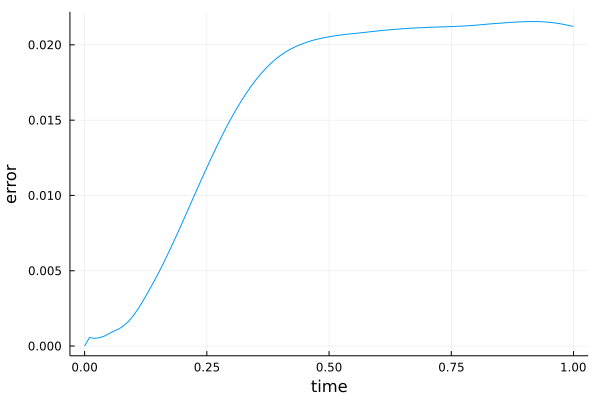

In [56]:
true_trajs = [hcat([sol[:,k] for sol in true_sols]...) for k in 1:length(savepoints)];
plot(savepoints, [norm(true_trajs[i] - Matrix(lr_sol.Y[i]))/m^2 for i in 1:length(savepoints)], xlabel = "time", ylabel = "error", legend =false)